In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR
from scipy.interpolate import splev, splprep

from tqdm import tqdm

import torch
 
from funciones import *

from tree_functions import *
from tree_viewer import *

import random

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def postorder_to_preorder_dataset(src, dest, k = 4):

    erase_all_files(dest)
    folders = os.listdir(src) 

    for folder in folders:
        file_list = os.listdir(src + "/" + folder)

        for file_name in file_list:
            file_path = os.path.join(src + "/" + folder, file_name)

            tree_data_np = np.load(file_path)
            tree_tensor = torch.tensor(tree_data_np, dtype=torch.float32)

            serial_tree = list(tree_tensor.flatten().numpy())
            tree = deserialize_post_order_k(serial_tree, k = k)

            serial_tree = serialize_pre_order_k(tree, k = 39)
            np_tree = np.array(serial_tree).reshape((-1, k))

            np.save(dest + "/" + folder + "-" + file_name, np_tree)

#postorder_to_preorder_dataset("./datasets/stage1/train/numpy_postorder", "./datasets/stage1/train/numpy_preorder", k = 39)

In [3]:
def preorder_to_postorder_dataset(src, dest, k = 4):

    erase_all_files(dest)
    folders = os.listdir(src)
    for folder in folders:
        file_list = os.listdir(src + "/" + folder)[:1]

        for file_name in file_list:
            file_path = os.path.join(src + "/" + folder, file_name)

            tree_data_np = np.load(file_path)
            tree_tensor = torch.tensor(tree_data_np, dtype=torch.float32)

            serial_tree = list(tree_tensor.flatten().numpy())
            tree = deserialize_pre_order_k(serial_tree, k = k)

            serial_tree = serialize_post_order_k(tree, k = 39)
            np_tree = np.array(serial_tree).reshape((-1, k))

            np.save(dest + "/" + folder + "-" + file_name, np_tree)

#postorder_to_preorder_dataset("./datasets/stage1/train/numpy_postorder", "./datasets/stage1/train/numpy_preorder", k = 39)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1244/1244 [00:53<00:00, 23.31it/s]

dataset size: 1244 | max token length 5024


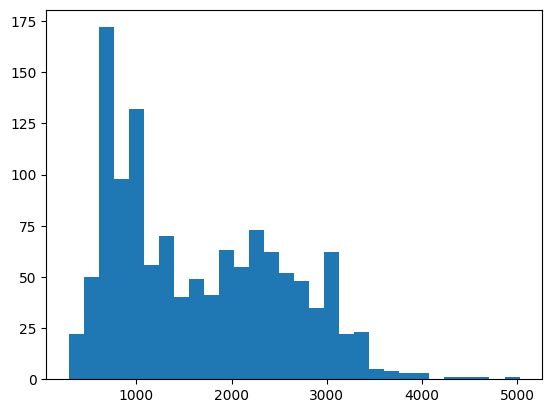

In [ ]:
def tokenize_dataset(src, dest, autoencoder, max_cap):

    token_lengths = []

    erase_all_files(dest + "/")
    file_list = sorted(os.listdir(src + "/"))

    for file_name in tqdm(file_list):
        data = np.load(src + "/" + file_name).reshape((-1,39))
        data = torch.tensor(data, dtype = torch.float32).unsqueeze(0).to(device)

        quant, indices = autoencoder.get_quant(data)  
        if file_name.endswith(".dat.npy"):
            file_name = file_name[:-8] + ".tok"  
        elif file_name.endswith(".npy"):
            file_name = file_name[:-4] + ".tok"

        if(len(indices) <= max_cap):

            torch.save(indices.cpu().flatten(), dest + "/" + file_name)
            token_lengths.append(len(indices.cpu().flatten()))

    plt.hist(token_lengths, bins = 30)
    print("dataset size:", len(token_lengths), "| max token length", max(token_lengths))


from Stage1.modelsMultitalk.stage1_vocaset import VQAutoEncoder 


args = Args()

args.in_dim = 39
args.hidden_size = 1024
args.feature_dim = 64
args.face_quan_num = 16
args.base_lr = 5e-3
args.step_size = 150
args.gamma = 0.9

autoencoder = VQAutoEncoder(args).to(device)

checkpoint = torch.load("models/stage1/aneux/best-model.pth", map_location = device)
autoencoder.load_state_dict(checkpoint['model_state_dict'])

autoencoder.eval()

# ------------------------------------------------------------------

tokenize_dataset("Data/Aneux+Intra-splines/p15/","Data/Aneux+Intra-splines/tokenized/nuevoquant/p15/", autoencoder, max_cap = 10000000000000)

In [ ]:
def detokenize_dataset(src, dest, mode = "pre_order", device = None, decoder = None):

    erase_all_files(dest + "/")
    file_list = os.listdir(src + "/")

    for file_name in tqdm(file_list):
        
        tokens = torch.load(src + "/" + file_name).to(device)

        tree = tokens_to_tree(tokens, mode = "pre_order", device = device, decoder = decoder)
        serial = serialize_post_order_str(tree)
        
        with open(dest + "/" + file_name[:-4] + ".dat", "w") as file:
            file.write(serial)

#detokenize_dataset("generated/dataset_aneurisk_zero/tokenized/tmp1.0", "generated/dataset_aneurisk_zero/numpy_postorder/tmp1.0", device = device, decoder = autoencoder)

In [ ]:
def zero_root_dataset(src, dest):

    erase_all_files(dest + "/")
    file_list = os.listdir(src + "/")

    for file_name in tqdm(file_list):

        data = np.load(src + "/" + file_name)
        not_zero_mask = np.mean(data, axis = 1) != 0

        data[not_zero_mask,:-1] = data[not_zero_mask,:-1] - data[0,:-1]

        np.save(dest + "/" + file_name, data)

#zero_root_dataset("./datasets/dataset_aneurisk/p15Eps01_preorder", "./datasets/dataset_aneurisk_zero/p15Eps01_preorder")

In [ ]:
def rotate_3d(points, angle_degrees, axis):

    """
    Rotates a set of 3D points around a given axis by a specified angle.
    
    Parameters:
    points (numpy.ndarray): An Nx3 array of 3D points.
    angle (float): Rotation angle in degrees.
    axis (numpy.ndarray): A 3-element array representing the axis of rotation.
    
    Returns:
    numpy.ndarray: The rotated Nx3 array of points.
    """

    angle = np.radians(angle_degrees)
    axis = axis / np.linalg.norm(axis)  # Normalize the axis vector

    x, y, z = axis
    c = np.cos(angle)
    s = np.sin(angle)
    t = 1 - c

    R = np.array([
        [t*x*x + c,   t*x*y - s*z, t*x*z + s*y],
        [t*x*y + s*z, t*y*y + c,   t*y*z - s*x],
        [t*x*z - s*y, t*y*z + s*x, t*z*z + c]
    ])
    
    return np.dot(points, R.T)  

def rotate_dataset(src, dest, n_rot):
    
    erase_all_files(dest + "/")
    file_list = os.listdir(src + "/")

    for file_name in tqdm(file_list):

        data = np.load(src + "/" + file_name)
        data_rot = data.copy()

        for i in range(n_rot):

            data_rot[:,:-1] = rotate_3d(data_rot[:,:-1], random.randint(10, 350), np.random.rand(3))
            np.save(dest + "/rot" + str(i) + "-" + file_name, data_rot)

        np.save(dest + "/" + file_name, data)

#rotate_dataset("datasets/dataset_aneurisk_zero/numpy_preorder", "datasets/dataset_aneurisk_zero_rot/numpy_preorder", n_rot = 3)

In [22]:
def sample_spline(coeffs, n_samples):

	coeffs = list(coeffs)

	t = np.array(coeffs[24:])
	c = [np.array(coeffs[i*8:(i*8)+8]) for i in range(3)]

	tck = (t, c, 3)

	u = np.linspace(0, 1, n_samples)
	x, y, z = splev(u, tck)

	return np.column_stack((x, y, z))


def limpiarRadiosSplines(radius):
    cleaned = []

   # Step 2: Process the 4th element - list of 3 arrays (each padded to length 8)
    array_list = radius[1]
    for arr in array_list:
        arr = np.asarray(arr, dtype=np.float32)
        if len(arr) < 8:
            arr = np.pad(arr, (0, 8 - len(arr)), mode='edge')  # Repeat last value
        cleaned.extend(arr[:8])  # Ensure exactly 8

    # Step 3: Process the 5th element - array of length 12
    arr = np.asarray(radius[0], dtype=np.float32)
    if len(arr) < 12:
        arr = np.pad(arr, (0, 12 - len(arr)), mode='edge')  # Repeat last value
    cleaned.extend(arr[:12])  # Ensure exactly 12

    return cleaned


def fit_poly(values, degree):

	xs = np.linspace(0,1,len(values))
	coeffs = np.polyfit(xs, values, degree) 

	return coeffs

def all_elements_equal(l):
    return all(np.allclose(x, l[0], atol=1e-4) for x in l)

def splines_dataset(src, dest, n_rot, n_spline_samples = 50, mode = "pre_order"):
	erase_all_files(dest + "/")
	file_list = os.listdir(src + "/")
	for file_name in tqdm(file_list):
		
		data = np.load(src + "/" + file_name)
		
		data = data.reshape((-1,39))

		root = data[-1,:3] if mode == "post_order" else data[0,:3]
		not_zero_mask = np.mean(data, axis = 1) != 0

		for r in range(n_rot):

			#angle = random.randint(10,350) if r != 0 else 0
			#axis = np.random.rand(3)

			# SPLINE POINTS EXTRACTION --------------------------

			spline_points = np.zeros((len(data) * n_spline_samples, 3))

			j = 0
			for i, datum in enumerate(data):

				if np.any(datum):	# not zero row

					points = None

					if all_elements_equal(datum[3:11]):
						points = np.hstack((np.full(50, datum[0]).reshape(-1,1), np.full(50, datum[1]).reshape(-1,1), np.full(50, datum[2]).reshape(-1,1))) - root
					else:
						points = sample_spline(datum[3:], n_samples = n_spline_samples) - root
					
					spline_points[j * n_spline_samples : (j+1) * n_spline_samples] = points

				else:
					spline_points[j * n_spline_samples : (j+1) * n_spline_samples] = np.zeros((n_spline_samples, 3))

				j += 1

			# ZERO ROOT AND ROTATION ---------------------------
			
			data_xyz = data[:,:3].copy()

			data_xyz[not_zero_mask,:] = data_xyz[not_zero_mask,:] - root
			#data_xyz = rotate_3d(data_xyz, angle, axis)

			#spline_points = rotate_3d(spline_points, angle, axis)

			# DATA NORMALIZATION -------------------------------

			all_data = np.vstack((data_xyz, spline_points))
			abs_max = abs(all_data).max()
			all_data = all_data / abs_max

			data_xyz = all_data[:len(data_xyz),:]
			spline_points = all_data[len(data_xyz):,:]

			# SPLINE RECONSTRUCTION ----------------------------

			data_splines = []
			for i in range(0, len(data) * n_spline_samples, n_spline_samples):
				
				if np.any(spline_points[i: i + n_spline_samples]):

					xs = spline_points[i: i + n_spline_samples, 0].flatten()
					ys = spline_points[i: i + n_spline_samples, 1].flatten()
					zs = spline_points[i: i + n_spline_samples, 2].flatten()

					coeffs = None

					if all_elements_equal(xs):
						coeffs = list(xs[:8]) + list(ys[:8]) + list(zs[:8]) + [1.] * 12
					else:
						try:
							tck, _ = splprep([xs, ys, zs], s=0.0000001, per=True, nest = 12, k=3)
							coeffs = np.concatenate((tck[1][0], tck[1][1], tck[1][2], tck[0]))
						except:
							assert("ERROR EN SPLPREP")

					#new_row = np.concatenate((np.zeros((3)), coeffs))
					#print("new row antes", new_row)
					#new_row = fix_row_spline(new_row)
					new_row = limpiarRadiosSplines(tck)
					#print("new_row despues:", new_row)
					data_splines.append(new_row)

				else: data_splines.append(np.zeros(36))

			data_splines = np.array(data_splines)
			new_data = np.hstack((data_xyz, data_splines))

			if r != 0:
				np.save(dest + "/rot" + str(r) + "-" + file_name, new_data)
			else:
				np.save(dest + "/" + file_name, new_data)

splines_dataset("Data/Aneux+Intra-splines/p15/", "Data/Aneux+Intra-splines/aumentado/p15/", n_rot = 10, mode = "pre_order")

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1244/1244 [03:29<00:00,  5.95it/s]
